In [1]:
import numpy as np
import theano
import theano.tensor as th
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pandas as pd

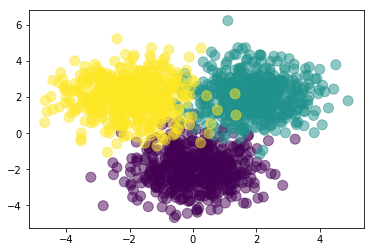

In [2]:
# create the data
Nclass = 500
D = 2 # dimensionality of input
M = 3 # hidden layer size
K = 3 # number of classes

X1 = np.random.randn(Nclass, D) + np.array([0, -2])
X2 = np.random.randn(Nclass, D) + np.array([2, 2])
X3 = np.random.randn(Nclass, D) + np.array([-2, 2])
X = np.vstack([X1, X2, X3])

Y = np.array([0]*Nclass + [1]*Nclass + [2]*Nclass)
N = len(Y)
# turn Y into an indicator matrix for training
T = np.zeros((N, K))
for i in range(N):
    T[i, Y[i]] = 1

# let's see what it looks like
plt.scatter(X[:,0], X[:,1], c=Y, s=100, alpha=0.5)
plt.show()

# randomly initialize weights
w1 = np.random.randn(D, M)
B1 = np.random.randn(M)
w2 = np.random.randn(M, K)
B2 = np.random.randn(K)

In [3]:
Y

array([0, 0, 0, ..., 2, 2, 2])

Neural Network from scratch

In [153]:
def forward(X, W1, b1, W2, b2):
    Z = 1 / (1 + np.exp(-X.dot(W1) - b1))
    A = Z.dot(W2) + b2
    expA = np.exp(A)
    Y = expA / expA.sum(axis=1, keepdims=True)
    return Y, Z

In [154]:
def cost(T, Y):
    dot_T_Y = np.sum(T * np.log(Y), axis = 1)
    return -dot_T_Y.sum()

In [155]:
def classification_rate(Y, P):
    n_correct = 0
    n_total = 0
    for i in range(len(Y)):
        n_total += 1
        if Y[i] == P[i]:
            n_correct += 1
    return float(n_correct) / n_total

In [156]:
def derivative_w2(Z, T, Y):
    return -Z.T.dot(T - Y)

In [157]:
def derivative_b2(T, Y):
    return (-(T - Y)).sum(axis=0)

In [158]:
def derivative_w1_sig(X, Z, T, Y, W2):
    dZ = (T - Y).dot(W2.T) * Z * ( 1 - Z)
    ret2 = X.T.dot(dZ)
    return -ret2

In [159]:
def derivative_b1_sig(T, Y, W2, Z):
    return (-(T - Y).dot(W2.T) * Z * (1-Z)).sum(axis=0)

cost: 2575.0911375184573 classification_rate: 0.3333333333333333
cost: 293.5476904113343 classification_rate: 0.9666666666666667
cost: 191.50504379569463 classification_rate: 0.9693333333333334
cost: 161.5126587250257 classification_rate: 0.9706666666666667
cost: 147.84382153032925 classification_rate: 0.9713333333333334
cost: 140.2259916777329 classification_rate: 0.9726666666666667
cost: 135.449721073134 classification_rate: 0.9726666666666667
cost: 132.2102545707524 classification_rate: 0.9733333333333334
cost: 129.88464642951897 classification_rate: 0.9733333333333334
cost: 128.1411266385307 classification_rate: 0.9733333333333334


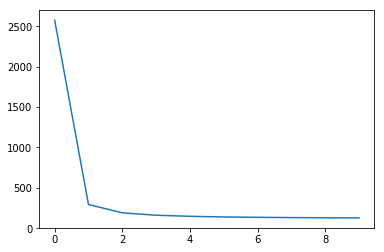

In [160]:
W1 = w1.copy()
b1 = B1.copy()
W2 = w2.copy()
b2 = B2.copy()

learning_rate = 1e-3
costs_sig = []
for epoch in range(200):
    output, hidden = forward(X, W1, b1, W2, b2)
    if epoch % 20 == 0:
        c = cost(T, output)
        P = np.argmax(output, axis=1)
        r = classification_rate(Y, P)
        print("cost:", c, "classification_rate:", r)
        costs_sig.append(c)

    # this is gradient ASCENT, not DESCENT
    # be comfortable with both!
    # oldW2 = W2.copy()
    W2 -= learning_rate * derivative_w2(hidden, T, output)
    b2 -= learning_rate * derivative_b2(T, output)
    W1 -= learning_rate * derivative_w1_sig(X, hidden, T, output, W2)
    b1 -= learning_rate * derivative_b1_sig(T, output, W2, hidden)
    
plt.plot(costs_sig)
plt.show()

Neural Network by Theano

In [161]:
def sigmoid(a):
    expA = np.exp(a)
    Y = expA / expA.sum(axis=1, keepdims=True)
    return Y

In [182]:
lr = 1e-3
#reg = 0.01

N, D = X.shape

M = 3
K = 3

In [183]:
#initialize theano variable and expressions

thX = th.matrix('X')
thT = th.matrix('T')
W1 = theano.shared(w1.copy(), 'W1')
b1 = theano.shared(B1.copy(), 'b1')
W2 = theano.shared(w2.copy(), 'W2')
b2 = theano.shared(B2.copy(), 'b2')

In [184]:
# we can use the built-in theano functions to do relu and softmax
thZ = sigmoid( thX.dot(W1) + b1 )  
thY = th.nnet.softmax( thZ.dot(W2) + b2 )

In [185]:
# define the cost function and prediction
cost = -(thT * th.log(thY)).sum() # + reg*((W1*W1).sum() + (b1*b1).sum() + (W2*W2).sum() + (b2*b2).sum())
prediction = th.argmax(thY, axis=1)

In [186]:
# training expressions and functions

update_W1 = W1 - lr*th.grad(cost, W1)
update_b1 = b1 - lr*th.grad(cost, b1)
update_W2 = W2 - lr*th.grad(cost, W2)
update_b2 = b2 - lr*th.grad(cost, b2)

In [187]:
train = theano.function(
    inputs=[thX, thT],
    updates=[(W1, update_W1), (b1, update_b1), (W2, update_W2), (b2, update_b2)],
)

In [188]:
# create another function for this because we want it over the whole dataset
get_prediction = theano.function(
    inputs=[thX, thT],
    outputs=[cost, prediction],
)

In [189]:
def error_rate(p, t):
    return np.mean(p != t)

cost 1599.280022921851 classification_rate 0.3886666666666667
cost 894.12715510561 classification_rate 0.74
cost 811.4373522976431 classification_rate 0.8886666666666667
cost 429.8829316184949 classification_rate 0.9473333333333334
cost 198.3922877800508 classification_rate 0.966
cost 159.83264435729342 classification_rate 0.9686666666666667
cost 146.42128058410972 classification_rate 0.972
cost 139.82650285604612 classification_rate 0.974
cost 135.82246581355898 classification_rate 0.974
cost 133.04916019798816 classification_rate 0.974


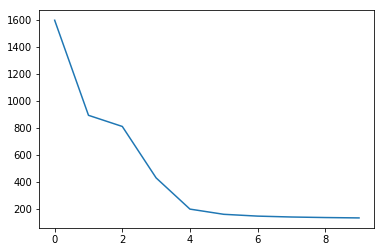

In [190]:
costs_theano = []
for epoch in range(200):
    train(X, T)
    if epoch % 20 == 0:
        cost_val, prediction_val = get_prediction(X, T)
        r = classification_rate(Y, prediction_val)
        err = error_rate(prediction_val, Y)
        
        print("cost", cost_val, "classification_rate", 1-err)
        costs_theano.append(cost_val)

plt.plot(costs_theano)
plt.show()

Tensorflow

In [171]:
lr = 1e-3
#reg = 0.01

N, D = X.shape

M = 3
K = 3

In [172]:
W1 = w1.copy()
b1 = B1.copy()
W2 = w2.copy()
b2 = B2.copy()

In [173]:
# define variables and expressions
tfX = tf.placeholder(tf.float32, shape=(None, D), name='X')
tfT = tf.placeholder(tf.float32, shape=(None, K), name='T')
tfW1 = tf.Variable(W1.astype(np.float32))
tfb1 = tf.Variable(b1.astype(np.float32))
tfW2 = tf.Variable(W2.astype(np.float32))
tfb2 = tf.Variable(b2.astype(np.float32))

In [174]:
# define the model
tfZ = tf.nn.sigmoid( tf.matmul(tfX, tfW1) + tfb1 )
tfA = tf.matmul(tfZ, tfW2) + tfb2

In [175]:
# softmax_cross_entropy_with_logits take in the "logits"
# if you wanted to know the actual output of the neural net,
# you could pass "A" into tf.nn.softmax(logits)
cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=tfA, labels=tfT))

In [176]:
# we choose the optimizer but don't implement the algorithm ourselves
# let's go with RMSprop, since we just learned about it.
# it includes momentum!

#train_op = tf.train.RMSPropOptimizer(lr, decay=0.99, momentum=0.9).minimize(cost)
train_op = tf.train.GradientDescentOptimizer(lr).minimize(cost)

In [177]:
predict_op = tf.argmax(tfA, 1)

In [178]:
def error_rate(p, t):
    return np.mean(p != t)

cost 1737.4543 classification_rate 0.030000000000000027
cost 288.17276 classification_rate 0.9666666666666667
cost 190.18849 classification_rate 0.9693333333333334
cost 160.93434 classification_rate 0.9706666666666667
cost 147.51785 classification_rate 0.972
cost 140.01556 classification_rate 0.9726666666666667
cost 135.30171 classification_rate 0.9733333333333334
cost 132.09991 classification_rate 0.9733333333333334
cost 129.79906 classification_rate 0.9733333333333334
cost 128.07289 classification_rate 0.9726666666666667


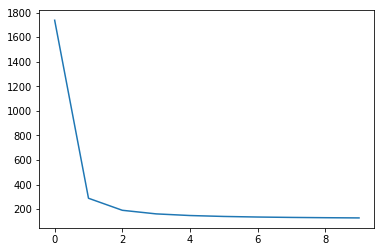

In [179]:
costs_tensorflow = []
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)

    for epoch in range(200):
        
        session.run(train_op, feed_dict={tfX: X , tfT: T})
        if epoch % 20 == 0:
            cost_val = session.run(cost, feed_dict={tfX: X, tfT: T})
            prediction_val = session.run(predict_op, feed_dict={tfX: X})
            err = error_rate(prediction_val, Y)
            #print(cost_val, prediction_val)
            print("cost", cost_val, "classification_rate", 1-err)
            costs_tensorflow.append(cost_val)

plt.plot(costs_tensorflow)
plt.show()

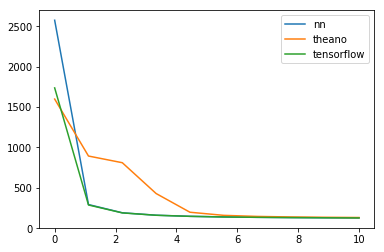

In [191]:
x1 = np.linspace(0, 10, len(costs_sig))
plt.plot(x1, costs_sig, label="nn")
x2 = np.linspace(0, 10, len(costs_theano))
plt.plot(x2, costs_theano, label="theano")
x3 = np.linspace(0, 10, len(costs_tensorflow))
plt.plot(x3, costs_tensorflow, label="tensorflow")
plt.legend()
plt.show()